<a href="https://colab.research.google.com/github/thiago-roque07/Hyperscanning-EEG-Tutorial/blob/main/EEG_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import glob, os
from google.colab import files

In [2]:
!pip install mne
import mne
mne.set_log_level(verbose='error')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 7.6 MB/s 


In [3]:
!wget https://github.com/thiago-roque07/Hyperscanning-EEG-Tutorial/raw/main/conversation_eeg_sample_decim-raw.fif
!wget https://raw.githubusercontent.com/thiago-roque07/Hyperscanning-EEG-Tutorial/main/conversation_eeg_sample.csv

--2022-10-06 19:56:16--  https://github.com/thiago-roque07/Hyperscanning-EEG-Tutorial/raw/main/conversation_eeg_sample_decim-raw.fif
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/thiago-roque07/Hyperscanning-EEG-Tutorial/main/conversation_eeg_sample_decim-raw.fif [following]
--2022-10-06 19:56:17--  https://raw.githubusercontent.com/thiago-roque07/Hyperscanning-EEG-Tutorial/main/conversation_eeg_sample_decim-raw.fif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81211080 (77M) [application/octet-stream]
Saving to: ‘conversation_eeg_sample_decim-raw.fif’

conversation_eeg_sa 100%[=============

In [4]:
# "Subject" is the name of your input file, without the extensions

subject = 'conversation_eeg_sample' 
eeg_extension = '_decim-raw.fif'

# Input should be continuous EEG data 
eeg_dataset = subject + eeg_extension

# Filter cutoffs and other parameters
l_freq_use = 0.1
l_freq_ICA = 1.0
h_freq = 20.0

# specify the time window for epoching
tmin = -0.2  # start of each epoch (in sec)
tmax =  1.0  # end of each epoch (in sec)

# maximum number of ICs to reject in ICA artifact correction
ica_random_state = 42  # seed so ICA is reproducable each time it's run
# Specify n_components as a decimal to set % explained variance
n_components = .99

baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(eeg=200e-6, eog=200e-6)  # EEG data are in V, so e-6 gives microVolts

# standard montage file to look up channel locations
montage_fname = 'standard_1005'

In [ ]:
raw_decim = mne.io.read_raw_fif(eeg_dataset, preload='True')

In [ ]:
mne.set_bipolar_reference(raw_decim, 
                          ['P1_RN','P1_LMass','P1_LN','P1_RMass'],
                          ['P2_RN','P2_LMass','P2_LN','P2_RMass'], 
                          ch_name=['P1_EMG_L', 'P2_EMG_L','P1_EMG_R','P2_EMG_R'], 
                          ch_info=None, 
                          copy=False)

<Raw | conversation_eeg_sample_decim-raw.fif, 62 x 307550 (615.1 s), ~145.5 MB, data loaded>

In [ ]:
raw_decim_use = raw_decim.copy()

# filter for input to ICA
raw_decim.filter(l_freq_ICA, h_freq)  

# Filter for ERP derviation
raw_decim_use.filter(l_freq_use, h_freq);

In [ ]:
word_codes = {'P1_heard':1,
             'P2_heard':2}  

In [ ]:
timings_file = subject + '.csv'
word_timings = pd.read_csv(timings_file)

# the Events data structure represents the 'when' in terms of samples
# not time. So convert seconds to samples
word_timings['onset_time'] = word_timings['onset_time'] * raw_decim.info['sfreq']

In [ ]:
events = np.c_[word_timings['onset_time'], 
               word_timings['dontuse'], 
               word_timings['text'].map(word_codes)
              ].astype(int)

# remove any events flagged as "don't use"
events = events[events[:,1] != 1]


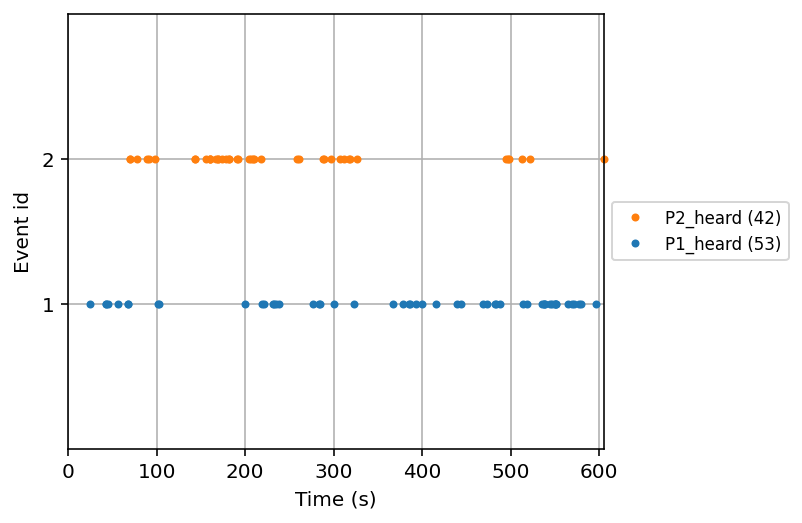

In [ ]:
mne.viz.plot_events(events, raw_decim.info['sfreq'], event_id=word_codes);

In [ ]:
p1_epochs = mne.Epochs(raw_decim, events, word_codes['P1_heard'],
                    tmin, tmax, 
                    proj=False,
                    baseline=baseline, 
                    detrend=1,
                    preload=True)

p1_epochs_use = mne.Epochs(raw_decim_use, events, word_codes['P1_heard'],
                        tmin, tmax, 
                        proj=False,
                        baseline=baseline, 
                        detrend=1,
                        preload=True)

In [ ]:
len(p1_epochs)

53

In [ ]:
p2_epochs = mne.Epochs(raw_decim, events, word_codes['P2_heard'],
                    tmin, tmax, 
                    proj=False,
                    baseline=baseline, 
                    detrend=1,
                    preload=True)

p2_epochs_use = mne.Epochs(raw_decim_use, events, word_codes['P2_heard'],
                        tmin, tmax, 
                        proj=False,
                        baseline=baseline, 
                        detrend=1,
                        preload=True)

In [ ]:
len(p2_epochs)

42

In [ ]:
p1_unused_chans = ['P2_Fp1','P2_Fp2','P2_F7','P2_F3','P2_Fz','P2_F4','P2_F8','P2_FC5',
                   'P2_FC1','P2_FC2','P2_FC6','P2_T7','P2_C3','P2_Cz','P2_C4','P2_T8',
                   'P2_TP9','P2_CP5','P2_CP1','P2_CP2','P2_CP6','P2_TP10','P2_P3',
                   'P2_Pz','P2_P4','P2_O1','P2_Oz','P2_O2','P2_EMG_L','P2_EMG_R',
                   'P2_Canthi']

p1_epochs.drop_channels(p1_unused_chans)
p1_epochs_use.drop_channels(p1_unused_chans)


p2_unused_chans = ['P1_Fp1','P1_Fp2','P1_F7','P1_F3','P1_Fz','P1_F4','P1_F8','P1_FC5',
                   'P1_FC1','P1_FC2','P1_FC6','P1_T7','P1_C3','P1_Cz','P1_C4','P1_T8',
                   'P1_TP9','P1_CP5','P1_CP1','P1_CP2','P1_CP6','P1_TP10','P1_P3',
                   'P1_Pz','P1_P4','P1_O1','P1_Oz','P1_O2','P1_EMG_L','P1_EMG_R',
                   'P1_Canthi']

p2_epochs.drop_channels(p2_unused_chans)
p2_epochs_use.drop_channels(p2_unused_chans);

In [ ]:
p1_channel_names = {'P1_Fp1':'Fp1', 'P1_Fp2':'Fp2', 'P1_F7':'F7', 'P1_F3':'F3', 'P1_Fz':'Fz', 
                    'P1_F4':'F4', 'P1_F8':'F8', 'P1_FC5':'FC5', 'P1_FC1':'FC1', 'P1_FC2':'FC2', 
                    'P1_FC6':'FC6', 'P1_T7':'T7', 'P1_C3':'C3', 'P1_Cz':'Cz', 'P1_C4':'C4', 
                    'P1_T8':'T8', 'P1_TP9':'TP9', 'P1_CP5':'CP5', 'P1_CP1':'CP1', 'P1_CP2':'CP2', 
                    'P1_CP6':'CP6', 'P1_TP10':'TP10', 'P1_P3':'P3', 'P1_Pz':'Pz', 
                    'P1_P4':'P4', 'P1_O1':'O1', 'P1_Oz':'Oz', 
                    'P1_O2':'O2', 'P1_Canthi':'EOG'}

p2_channel_names = {'P2_Fp1':'Fp1', 'P2_Fp2':'Fp2', 'P2_F7':'F7', 
                    'P2_F3':'F3', 'P2_Fz':'Fz', 'P2_F4':'F4', 'P2_F8':'F8', 'P2_FC5':'FC5', 'P2_FC1':'FC1', 
                    'P2_FC2':'FC2', 'P2_FC6':'FC6', 'P2_T7':'T7', 'P2_C3':'C3', 'P2_Cz':'Cz', 'P2_C4':'C4', 
                    'P2_T8':'T8', 'P2_TP9':'TP9', 'P2_CP5':'CP5', 'P2_CP1':'CP1', 'P2_CP2':'CP2', 
                    'P2_CP6':'CP6', 'P2_TP10':'TP10', 'P2_P3':'P3', 'P2_Pz':'Pz', 
                    'P2_P4':'P4', 'P2_O1':'O1', 'P2_Oz':'Oz', 
                    'P2_O2':'O2', 'P2_Canthi':'EOG'}

mne.rename_channels(p1_epochs.info, p1_channel_names)
mne.rename_channels(p1_epochs_use.info, p1_channel_names)
mne.rename_channels(p2_epochs.info, p2_channel_names)
mne.rename_channels(p2_epochs_use.info, p2_channel_names)

In [ ]:
p1_epochs.set_montage(montage_fname)
p2_epochs.set_montage(montage_fname)
p1_epochs_use.set_montage(montage_fname)
p2_epochs_use.set_montage(montage_fname);

In [ ]:
p1_epochs = mne.set_eeg_reference(p1_epochs)[0]
p2_epochs = mne.set_eeg_reference(p2_epochs)[0]
p1_epochs_use = mne.set_eeg_reference(p1_epochs_use)[0]
p2_epochs_use = mne.set_eeg_reference(p2_epochs_use)[0];

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


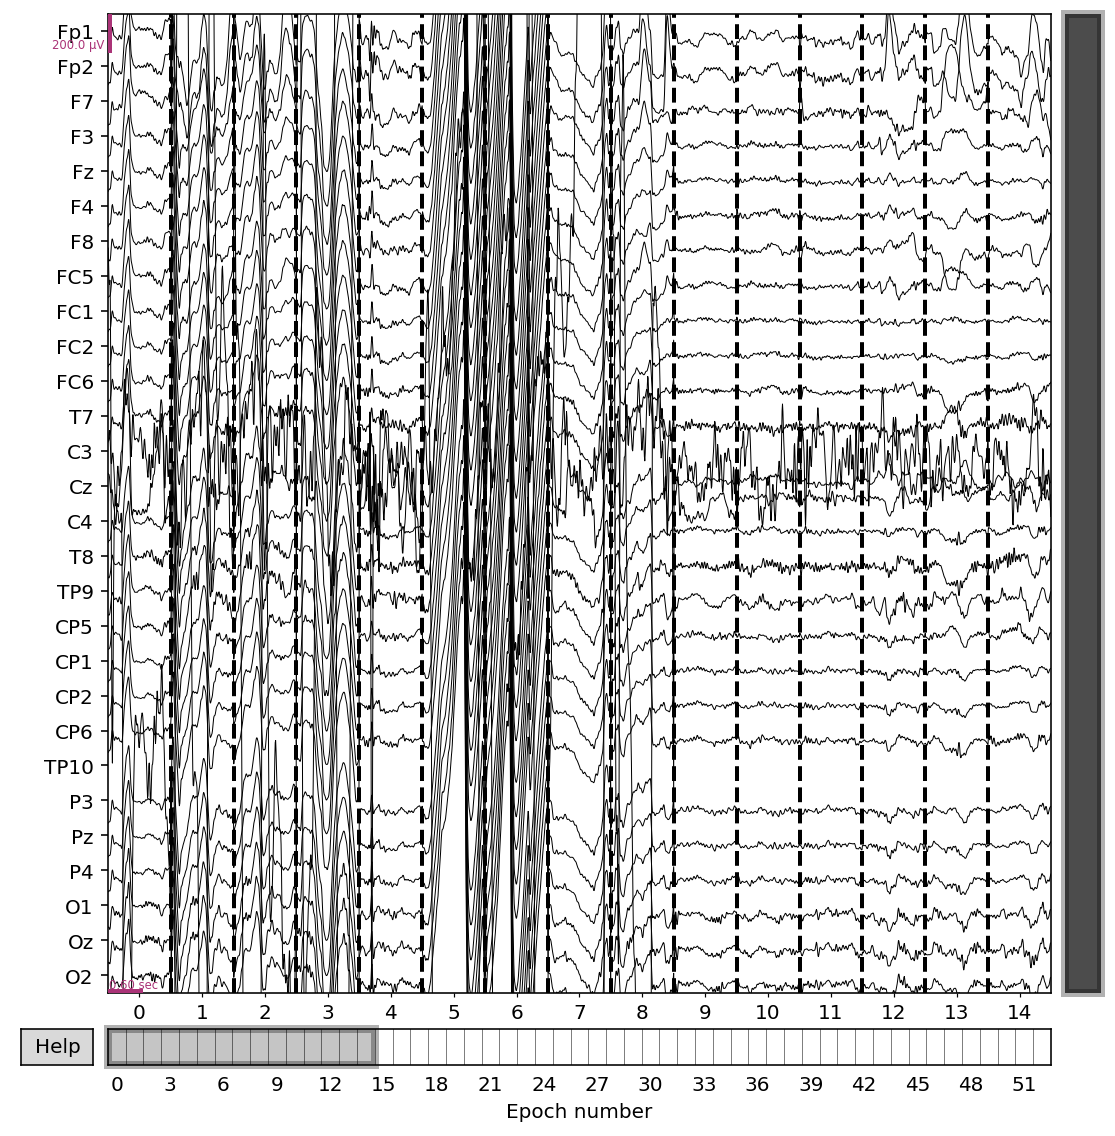

In [ ]:
%gui qt

p1_epochs.plot(n_channels=34, 
               n_epochs=15, 
               scalings=dict(eeg=.0001, eog=.0005, emg=.0005),
               decim=4,
               title='P1');

In [ ]:
p1_bads = ['TP10', 'C3','T7','TP9','T8','Cz']

# List any bad channels
p1_epochs.info['bads'] = p1_bads
# Re-reference to average that doesn't include bad channels
p1_epochs = mne.set_eeg_reference(p1_epochs)[0]

# apply to less-filtered data as well
p1_epochs_use.info['bads'] = p1_bads
p1_epochs_use = mne.set_eeg_reference(p1_epochs_use)[0]

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


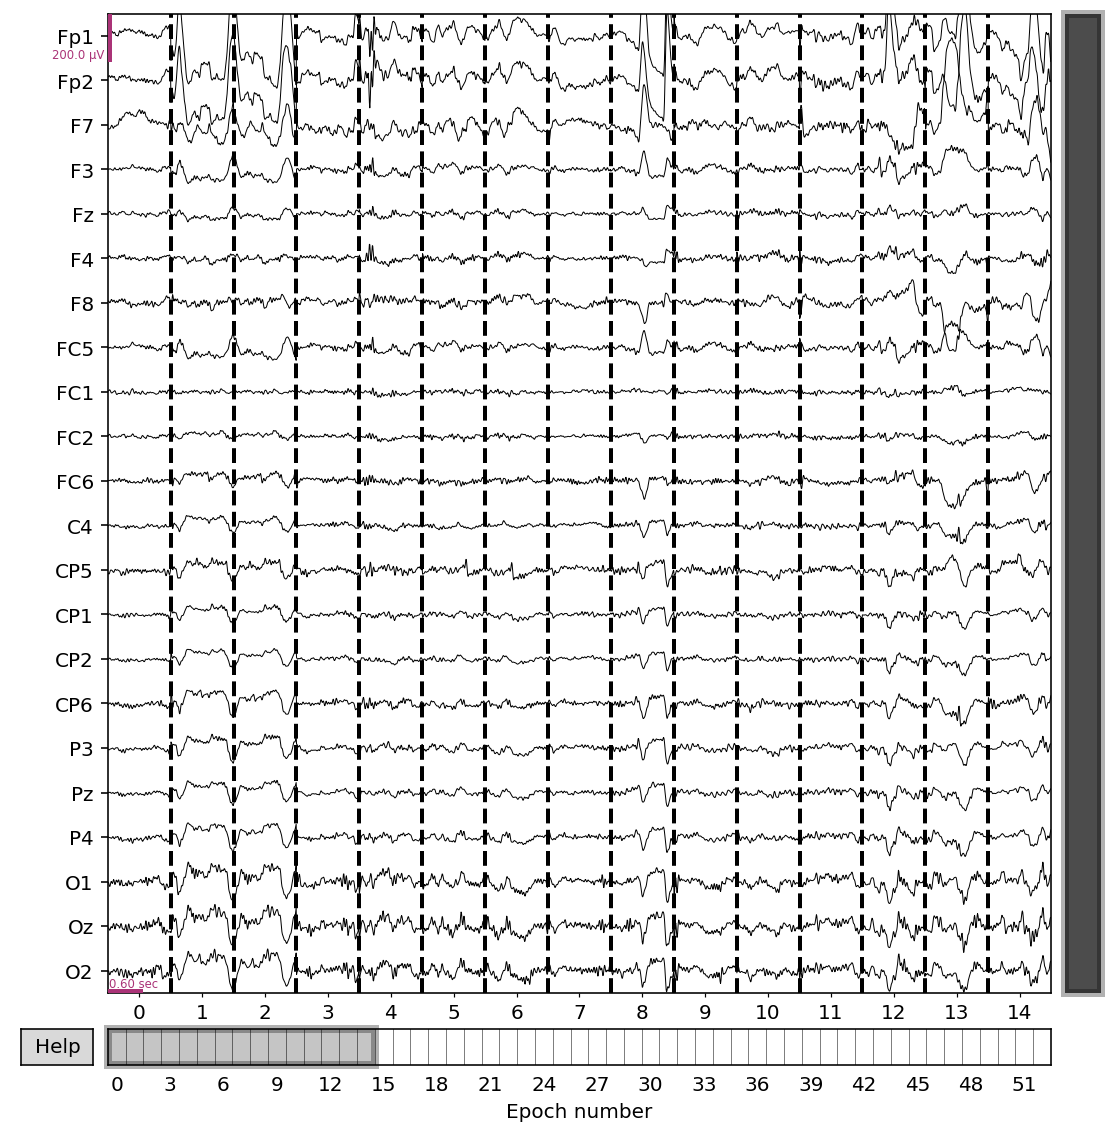

In [ ]:
p1_epochs.plot(n_channels=34, 
               n_epochs=15, 
               scalings=dict(eeg=.0001, eog=.0005, emg=.0005),
               decim=4,
               title='P1');

In [ ]:
# list any bad trials
rej_trials = [] 
    
p1_epochs.drop(rej_trials)
p1_epochs_use.drop(rej_trials);

In [ ]:
ica = mne.preprocessing.ICA(n_components=n_components, method='fastica', 
                            max_iter=500, random_state=ica_random_state)

picks = mne.pick_types(p1_epochs.info, 
                       eeg=True, eog=False, emg=False, misc=False, stim=False, meg=False, 
                       exclude='bads')

ica.fit(p1_epochs, picks=picks, decim=3, reject=None)

<ICA | epochs decomposition, method: fastica (fit in 29 iterations on 10653 samples), 8 ICA components explaining 99.1 % of variance (22 PCA components available), channel types: eeg, no sources marked for exclusion>

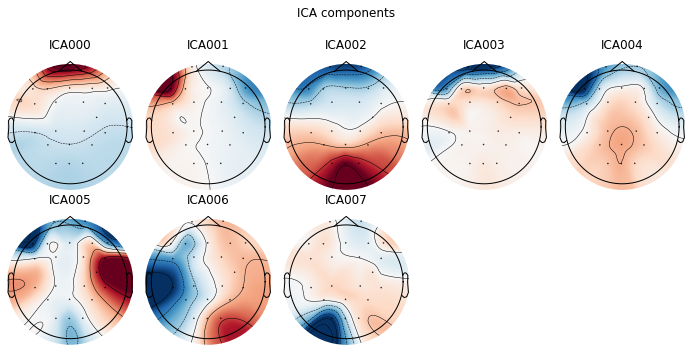

In [ ]:
%matplotlib inline
ica.plot_components(picks=None, ch_type='eeg');

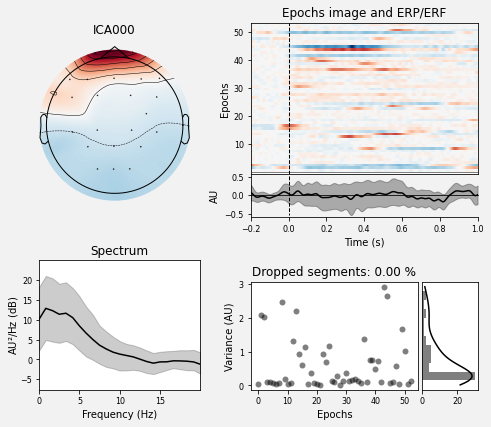

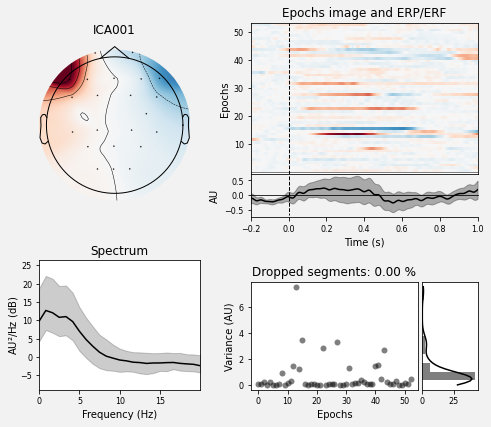

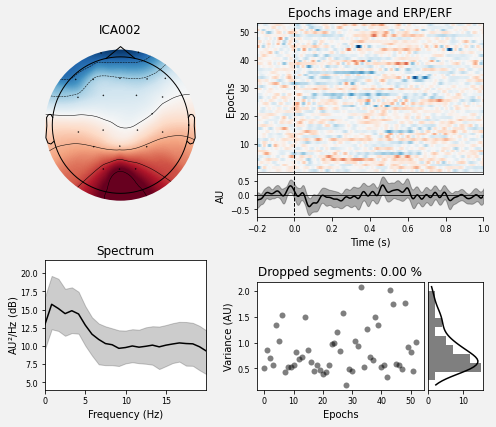

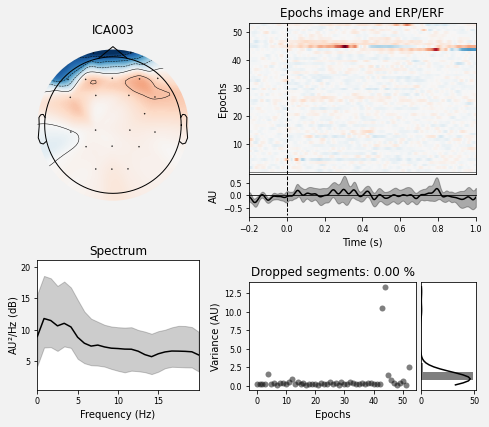

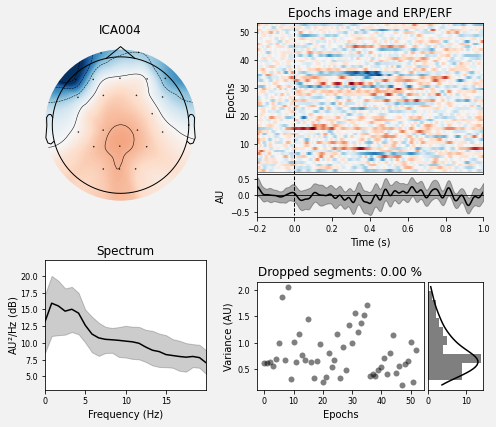

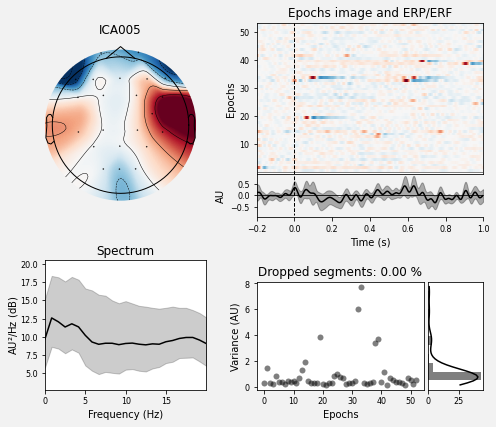

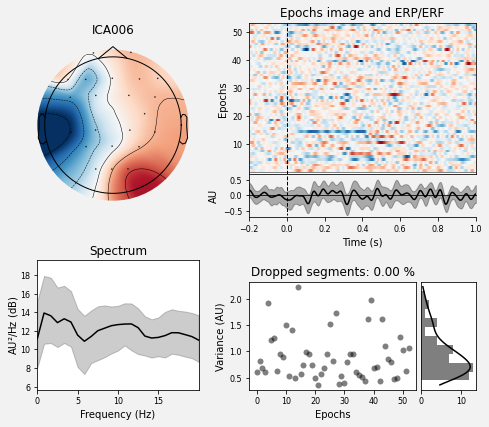

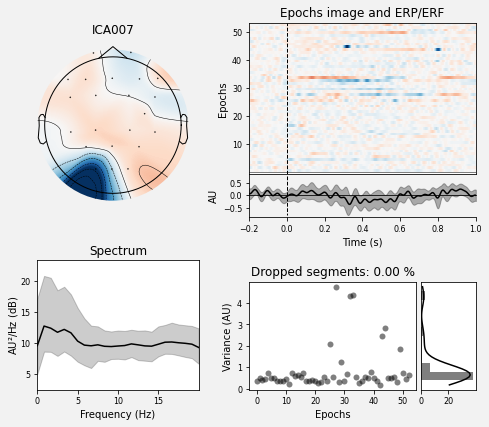

In [ ]:
ica.plot_properties(p1_epochs, 
                    picks=range(0, ica.n_components_), 
                    psd_args={'fmax': h_freq});

In [ ]:
ica.exclude = [0, 1, 3, 7]

In [ ]:
p1_epochs_postica = ica.apply(p1_epochs_use).apply_baseline(baseline)

In [ ]:
p1_epochs_postica.interpolate_bads();

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


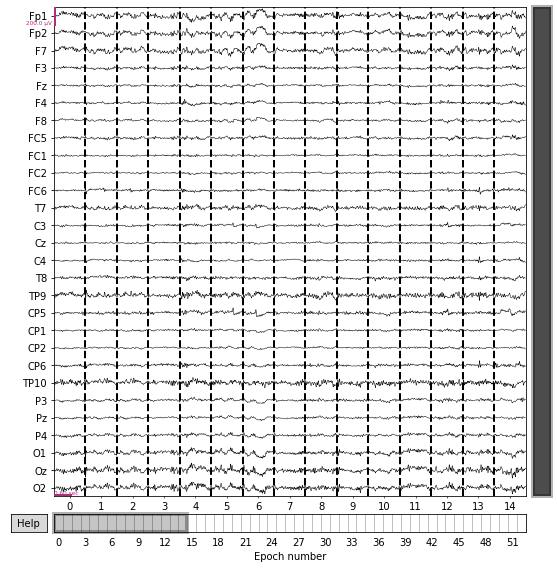

In [ ]:
%gui qt

p1_epochs_postica.plot(n_channels=32,
                       n_epochs=15, 
                       scalings=dict(eeg=.0001, eog=.0005, emg=.00045),
                       decim=4,
                       title='P1 Post-ICA');

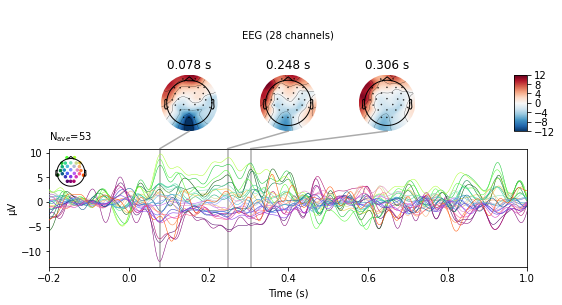

In [ ]:
%matplotlib inline
p1_epochs_postica.average().plot_joint();

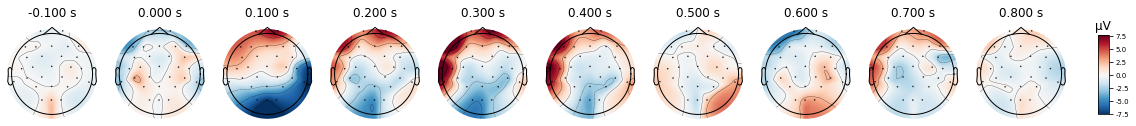

In [ ]:
times = np.arange(tmin+.1, tmax-.1, 0.1)
p1_epochs_postica.average().plot_topomap(times=times);

In [ ]:
p1_epochs_postica.save(subject + '-P1-epo.fif', overwrite=True)

Overwriting existing file.


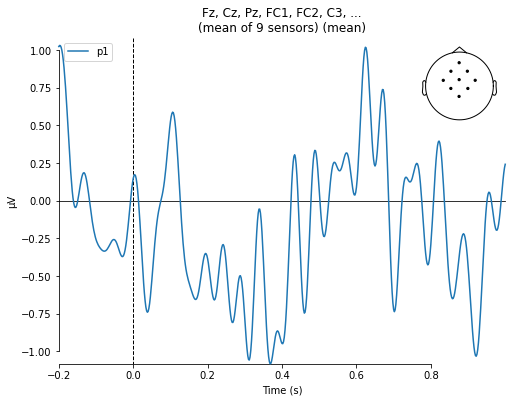

[<Figure size 576x432 with 2 Axes>]

In [ ]:
ROI_labels = ["Fz", "Cz", "Pz", "FC1", "FC2", "C3", "C4", "CP1", "CP2"]

p1_evoked = p1_epochs_postica.average().apply_baseline(baseline)

mne.viz.plot_compare_evokeds(dict(p1=p1_evoked),
                             legend='upper left', show_sensors='upper right', picks= ROI_labels, combine = 'mean')

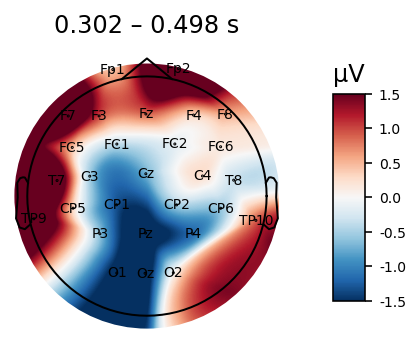

In [ ]:
import matplotlib

matplotlib.rcParams['figure.dpi'] = 144

uv_range = 1.5

p1_avg = {}

p1_avg = p1_epochs_postica.average().apply_baseline(baseline)


fig=p1_avg.plot_topomap(times=.400, average=.200, 
                    ch_type='eeg', show_names=True, colorbar=True, contours=False,
                             size=1.5, res=256,
                    vmin=-uv_range, vmax=uv_range,
                    image_interp='cubic',
                    sensors=True);

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


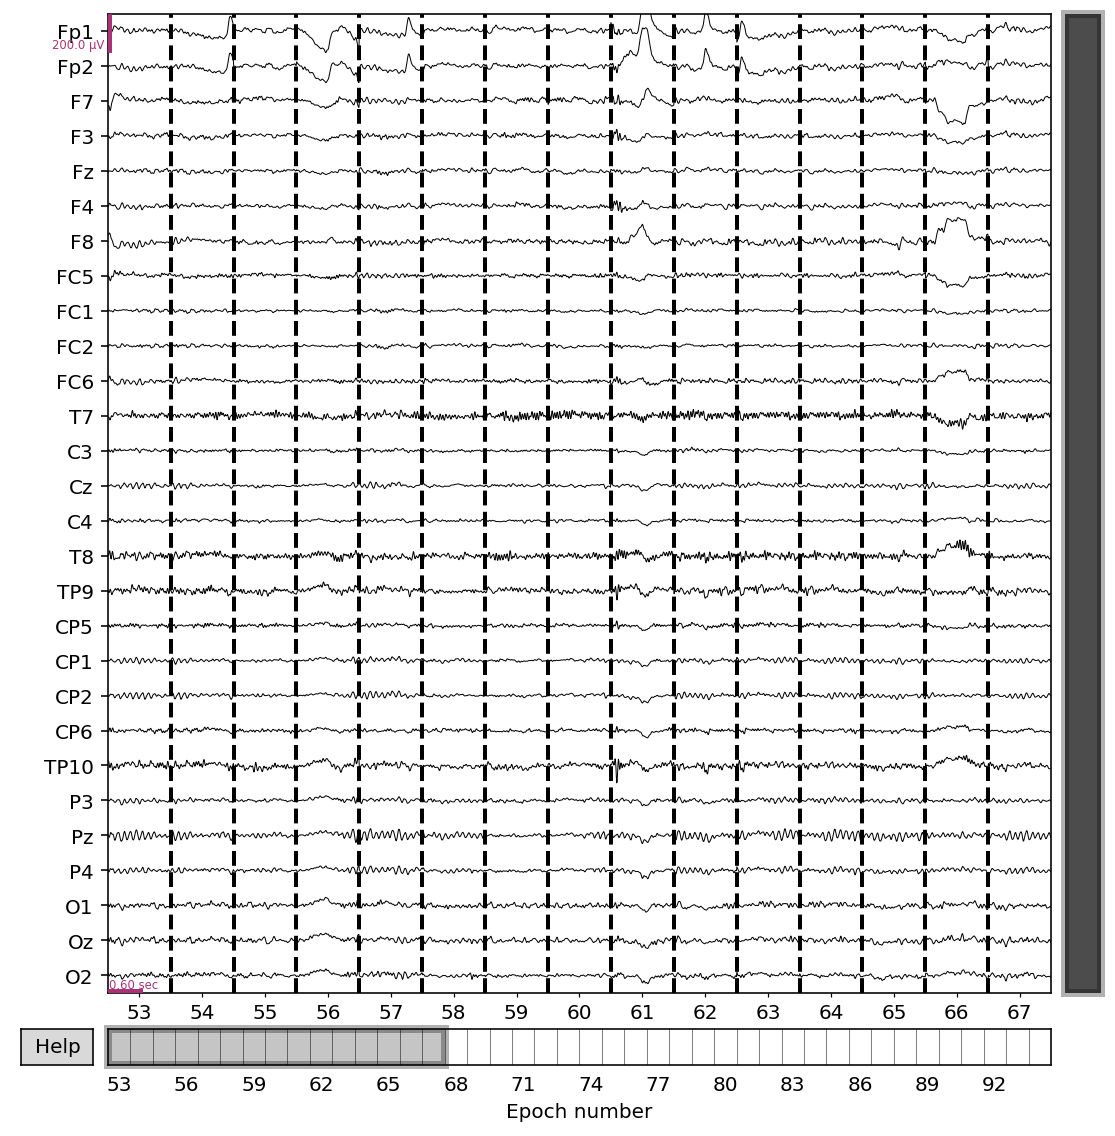

In [ ]:
%gui qt
p2_epochs.plot(n_channels=34, 
               n_epochs=15, 
               scalings=dict(eeg=.0001, eog=.0005, emg=.0005),
               decim=4,
               title='P2');

In [ ]:
p2_bads = []

# List any bad channels
p2_epochs.info['bads'] = p2_bads
# Re-reference to average that doesn't include bad channels
p2_epochs = mne.set_eeg_reference(p2_epochs)[0]

# apply to less-filtered data as well
p2_epochs_use.info['bads'] = p2_bads
p2_epochs_use = mne.set_eeg_reference(p2_epochs_use)[0]

In [ ]:
# list any bad trials
rej_trials = [] 
    
p2_epochs.drop(rej_trials)
p2_epochs_use.drop(rej_trials);

In [ ]:
ica = mne.preprocessing.ICA(n_components=n_components, method='fastica', 
                            max_iter=500, random_state=ica_random_state)

picks = mne.pick_types(p2_epochs.info, 
                       eeg=True, eog=False, emg=False, misc=False, stim=False, meg=False, 
                       exclude='bads')

ica.fit(p2_epochs, picks=picks, decim=3, reject=None)

<ICA | epochs decomposition, method: fastica (fit in 50 iterations on 8442 samples), 15 ICA components explaining 99.2 % of variance (28 PCA components available), channel types: eeg, no sources marked for exclusion>

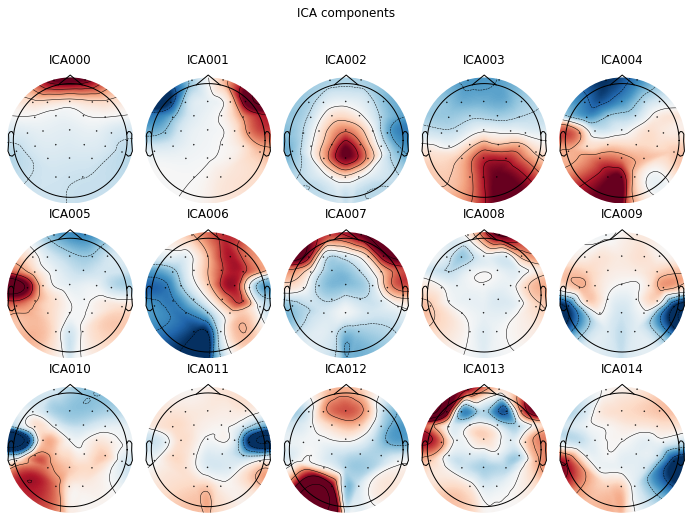

In [ ]:
%matplotlib inline
ica.plot_components(picks=None, ch_type='eeg');

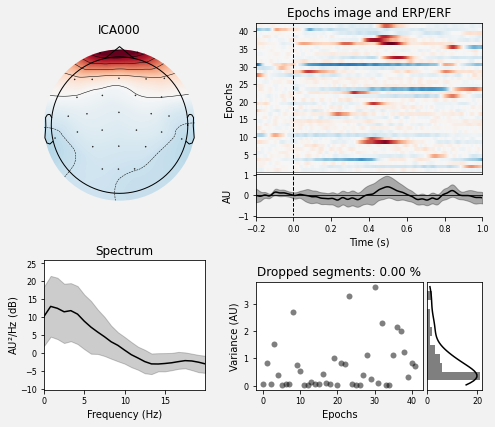

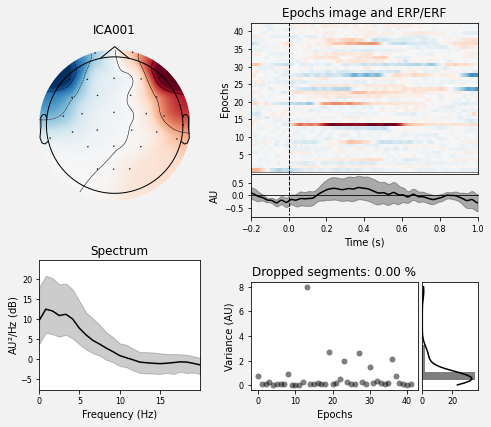

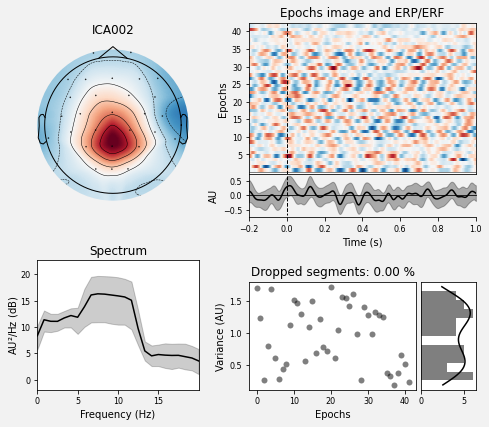

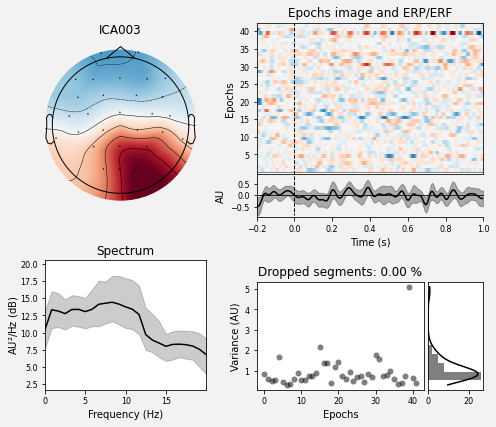

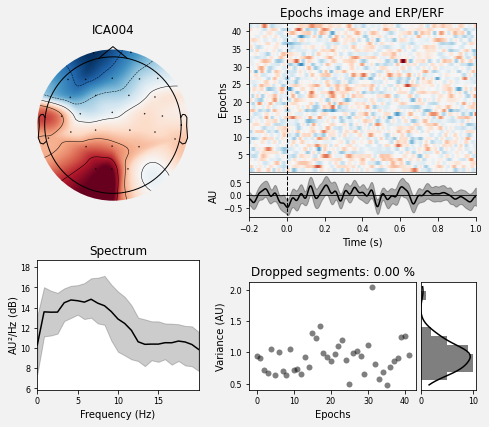

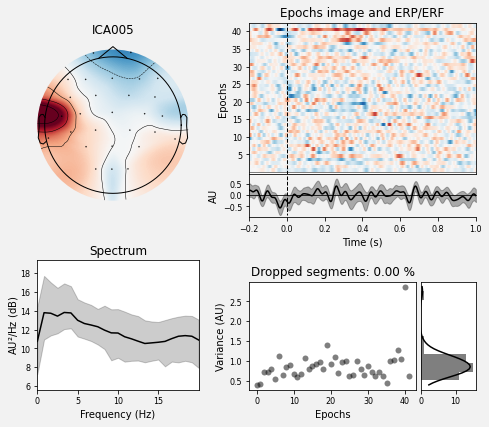

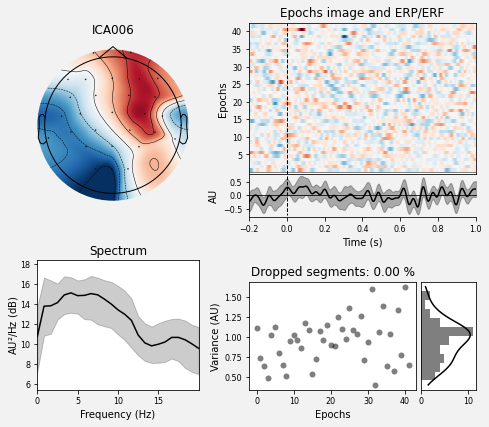

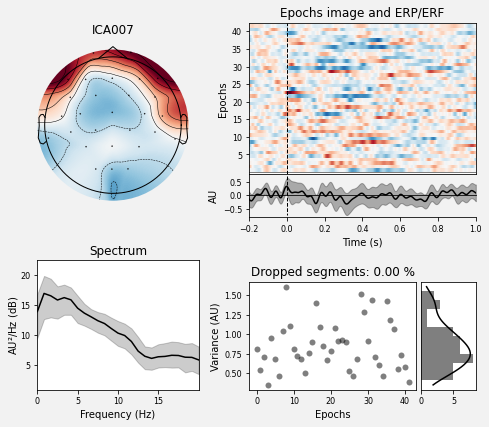

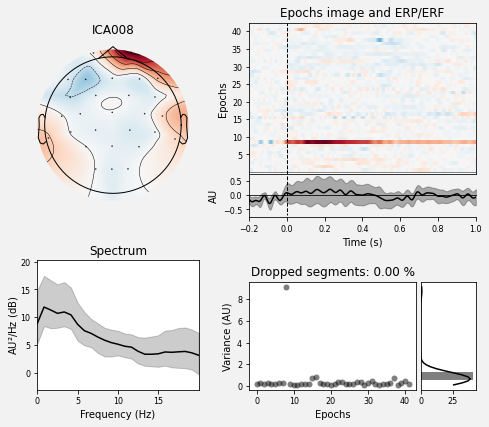

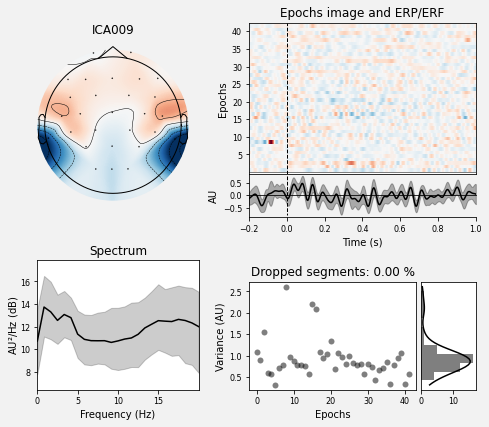

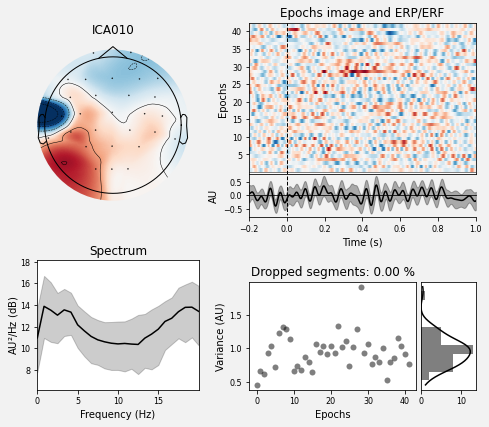

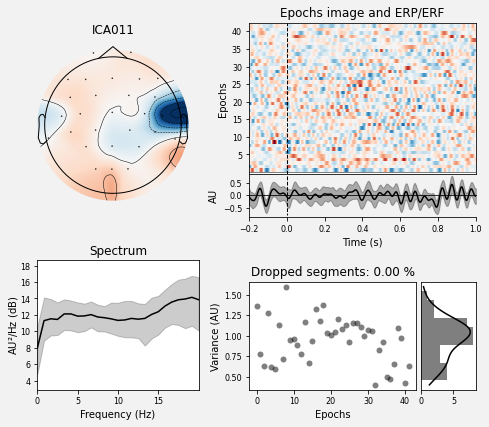

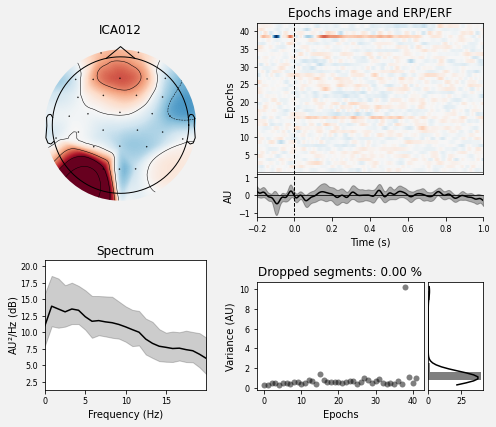

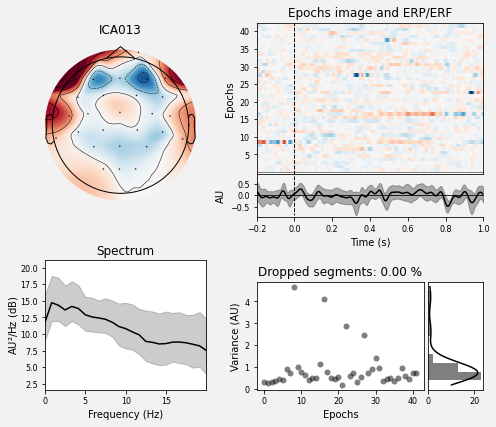

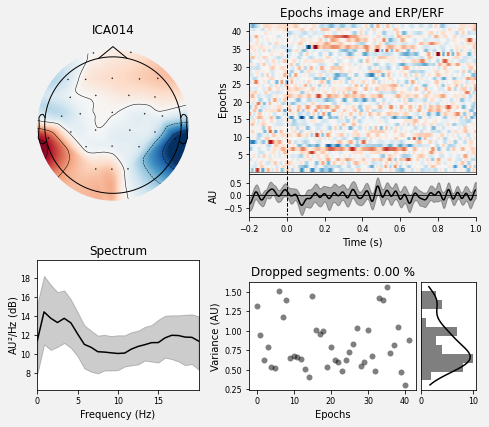

In [ ]:
ica.plot_properties(p2_epochs, 
                    picks=range(0, ica.n_components_), 
                    psd_args={'fmax': h_freq});

In [ ]:
ica.exclude = [0,1,8,13]

In [ ]:
p2_epochs_postica = ica.apply(p2_epochs_use).apply_baseline(baseline)

In [ ]:
p2_epochs_postica.interpolate_bads();

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


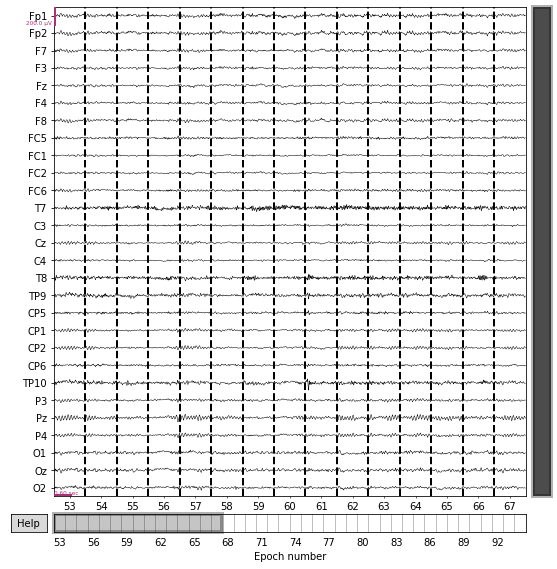

In [ ]:
%gui qt
p2_epochs_postica.plot(n_channels=32,
                       n_epochs=15, 
                       scalings=dict(eeg=.0001, eog=.0005, emg=.00045),
                       decim=4,
                       title='P2 Post-ICA');

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


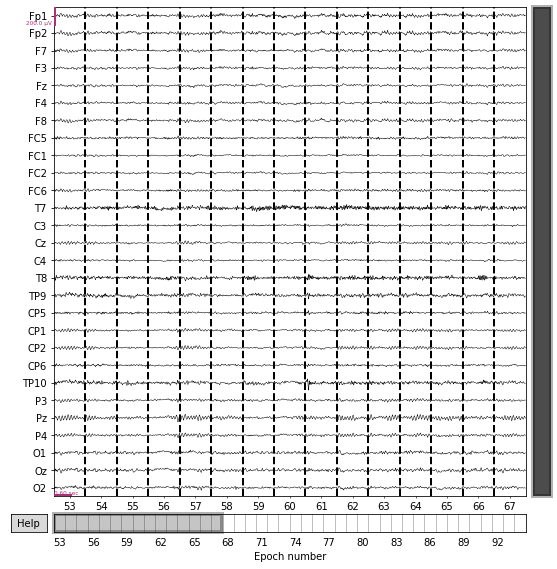

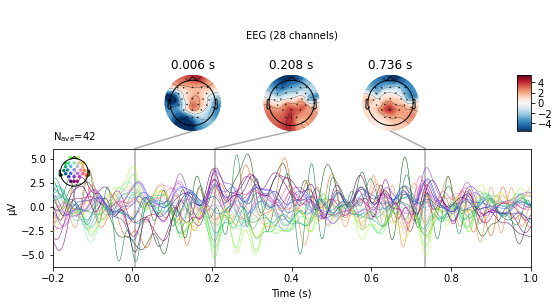

In [ ]:
%matplotlib inline
%gui qt
p2_epochs_postica.plot(n_channels=32,
                       n_epochs=15, 
                       scalings=dict(eeg=.0001, eog=.0005, emg=.00045),
                       decim=4,
                       title='P2 Post-ICA');
p2_epochs_postica.average().plot_joint();

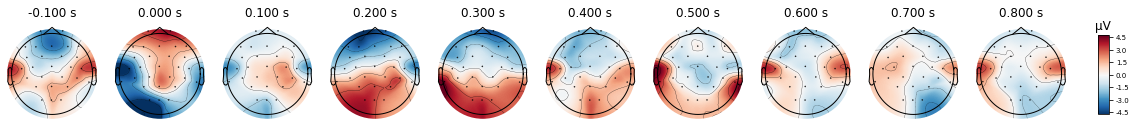

In [ ]:
times = np.arange(tmin+.1, tmax-.1, 0.1)
p2_epochs_postica.average().plot_topomap(times=times);

In [ ]:
p2_epochs_postica.save(subject + '-P2-epo.fif', overwrite=True)

Overwriting existing file.


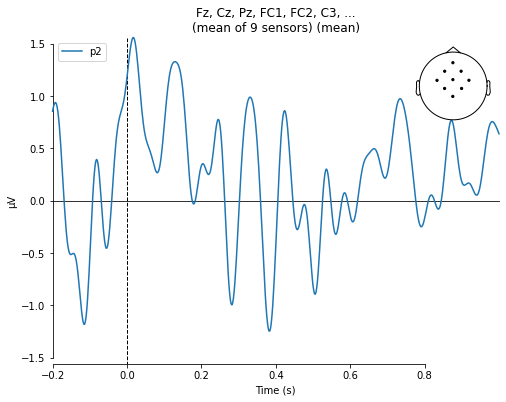

[<Figure size 576x432 with 2 Axes>]

In [ ]:
ROI_labels = ["Fz", "Cz", "Pz", "FC1", "FC2", "C3", "C4", "CP1", "CP2"]

p2_evoked = p2_epochs_postica.average().apply_baseline(baseline)

mne.viz.plot_compare_evokeds(dict(p2=p2_evoked),
                             legend='upper left', show_sensors='upper right', picks= ROI_labels, combine = 'mean')

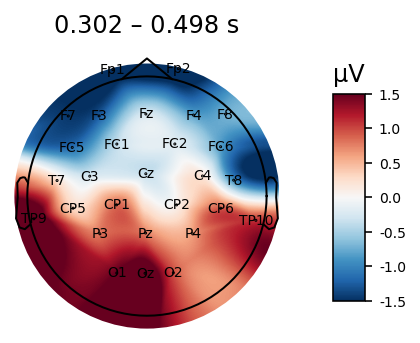

In [ ]:
matplotlib.rcParams['figure.dpi'] = 144

uv_range = 1.5

p2_avg = {}

p2_avg = p2_epochs_postica.average().apply_baseline(baseline)


fig=p2_avg.plot_topomap(times=.400, average=.200, 
                    ch_type='eeg', show_names=True, colorbar=True, contours=False,
                             size=1.5, res=256,
                    vmin=-uv_range, vmax=uv_range,
                    image_interp='cubic',
                    sensors=True);